In [ ]:
import torch
import torchvision
import os
from PIL import Image
import numpy as np
from google.colab import drive
from torch.utils.data import DataLoader, Dataset
from xml.dom.minidom import parse
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import matplotlib.pyplot as plt

In [ ]:
class Xaydataset(Dataset):

    def __init__(self, data_path, phase):
        self.data_path = data_path
        # if is_training:
        #     self.images_path = os.path.join(self.data_path, "train")
        # else:
            # self.images_path = os.path.join(self.data_path, "val")
        self.images_path = os.path.join(self.data_path, phase)   
        self.image_names = sorted(os.listdir(self.images_path))
        self.class_to_idx = {"Gun": 1, "Knife": 2, "Wrench": 3, "Pliers": 4}

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        full_image_path = os.path.join(self.images_path, self.image_names[idx])
        img = Image.open(full_image_path)

        dom = parse("{}/Annotation/{}.xml".format(self.data_path, self.image_names[idx].split(".")[0]))
        data = dom.documentElement

        objects = data.getElementsByTagName('object')
        width = data.getElementsByTagName('width')[0].childNodes[0].nodeValue
        height = data.getElementsByTagName('height')[0].childNodes[0].nodeValue
        height, width = float(height), float(width)
        boxes = []
        labels = []
        for obj in objects:
            name = obj.getElementsByTagName('name')[0].childNodes[0].nodeValue
            bndbox = obj.getElementsByTagName('bndbox')[0]
            xmin = bndbox.getElementsByTagName('xmin')[0].childNodes[0].nodeValue
            ymin = bndbox.getElementsByTagName('ymin')[0].childNodes[0].nodeValue
            xmax = bndbox.getElementsByTagName('xmax')[0].childNodes[0].nodeValue
            ymax = bndbox.getElementsByTagName('ymax')[0].childNodes[0].nodeValue
            labels.append(self.class_to_idx[name])
            boxes.append([xmin, ymin, xmax, ymax])

        H, W = height, width
        img = torchvision.transforms.functional.resize(img, (300, 300))
        o_H, o_W = img.size[0], img.size[1]
        for idx, bbox in enumerate(boxes):
            boxes[idx] = self.resize_bbox(bbox, (H, W), (o_H, o_W))

        img = torchvision.transforms.functional.to_tensor(img)
        # sample = dict()
        # sample["img"] = img
        # sample["size"] = [o_H, o_W]
        # sample["boxes"] = np.array(boxes)
        # sample["label"] = np.array(labels)

        return img,boxes,labels

    def resize_bbox(self,bbox, in_size, out_size):
      y_scale = float(out_size[0]) / in_size[0]
      x_scale = float(out_size[1]) / in_size[1]
      xmin = x_scale * float(bbox[0])
      ymin = y_scale * float(bbox[1])
      xmax = x_scale * float(bbox[2])
      ymax = y_scale * float(bbox[3])
      return [xmin, ymin, xmax, ymax]   

In [ ]:
drive.mount('/content/drive')
data_path="/content/drive/MyDrive/Project_CL2/dataset"
model_dir="/content/drive/MyDrive/Project_CL2/models"

Mounted at /content/drive


In [ ]:
batch_size= 10

def collate_fn(batch):
    return (zip(*batch))
train_dataset = Xaydataset(data_path, "train")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                              collate_fn=collate_fn)
val_dataset = Xaydataset(data_path, "val")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True, collate_fn=collate_fn)

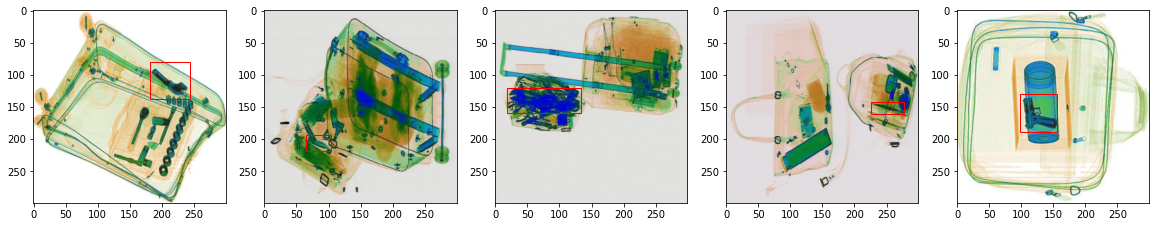

In [ ]:
img,boxes,labels = next(iter(train_dataloader))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    ax[i].imshow(img[i].permute(1, 2, 0))
    for box in boxes[i]:
      rect = plt.Rectangle((box[0], box[1]),box[2]-box[0],box[3]-box[1], fill=False, edgecolor = 'red',linewidth=1)
      ax[i].add_patch(rect)

plt.show()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Current Device : {}'.format(device))

Current Device : cuda


In [ ]:
class_to_idx = {"background": 0,"Gun": 1, "Knife": 2, "Wrench": 3}
num_classes=4
model = torchvision.models.detection.(pretrained=False,num_classes=num_classes, pretrained_backbone=True, trainable_backbone_layers=5)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0003, weight_decay=0.0005)
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
def train(model, optimizer, sample):
    model.train()

    img, boxes,labels = sample
    imgs = [image.to(device) for image in img]
    targets=[{'boxes':torch.tensor(boxes[i]).to(device),'labels':torch.tensor(labels[i]).to(device)} for i in range(len(imgs))]
    
    optimizer.zero_grad()
    losses = model(imgs, targets)
    sum_losses = sum(loss for loss in losses.values())
    sum_losses.backward()
    optimizer.step()
    return losses,sum_losses

# for idx, sample in enumerate(train_dataloader): 
#     losses=train(model, optimizer, sample)

In [ ]:
def voc_eval(pred_bboxes, pred_labels, pred_scores,gt_bboxes, gt_labels,indices,
      ovthresh=0.5,use_07_metric=False):
    
    pred_bboxes=np.array(pred_bboxes)
    pred_labels=np.array(pred_labels)
    pred_scores=np.array(pred_scores)
    sorted_ind = np.argsort(-pred_scores) 
    sorted_scores = np.sort(-pred_scores) 
    sorted_bb = pred_bboxes[sorted_ind, :]
    sorted_label=pred_labels[sorted_ind]

    ap_list=[]
    
    for c in range(num_classes):
      id=np.argwhere(sorted_label==c).flatten()
      num_gt=np.argwhere(np.array(gt_labels)==c).size
      if len(id)>0 and num_gt>0 :
        precison=np.zeros(len(id))
        recall=np.zeros(len(id))
        tp=0
        fp=0
        # tp = np.zeros(len(id)) 
        # fp = np.zeros(len(id)) 
        for i,j in enumerate(id):  
          gt_bb= gt_bboxes[int(indices[j])]
          gt_label= gt_labels[int(indices[j])]
          pred_label=pred_labels[j]
          pred_bb=pred_bboxes[j] 
          
          # iou 
          xA = max(gt_bb[0], pred_bb[0])
          yA = max(gt_bb[1], pred_bb[1])
          xB = min(gt_bb[2], pred_bb[2])
          yB = min(gt_bb[3], pred_bb[3])
          interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
          boxAArea = (gt_bb[2] - gt_bb[0] + 1) * (gt_bb[3] - gt_bb[1] + 1)
          boxBArea = (pred_bb[2] - pred_bb[0] + 1) * (pred_bb[3] - pred_bb[1] + 1)
          
          iou = interArea / float(boxAArea + boxBArea - interArea)
          if iou>=ovthresh:
            if gt_label==pred_label:
              tp +=1       
            else: 
              fp +=1
          else: 
            fp +=1
          precison[i]=tp/(tp+fp)
          recall[i]=tp/num_gt
        ap = voc_ap(recall, precison, use_07_metric)
        ap_list.append(ap)
    map= np.nanmean(ap_list)
    return ap_list,map

def voc_ap(rec, prec, use_07_metric=False):
   
    if use_07_metric:
       
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

       
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        i = np.where(mrec[1:] != mrec[:-1])[0]

       
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


In [ ]:
def eval(dataloader, model):
    model.eval()

    pred_bboxes, pred_labels, pred_scores = [],[],[]
    gt_bboxes, gt_labels= [],[]
    num=0
    indices=[]
    i=0
    for idx, sample in enumerate(dataloader):
        img, boxes,labels = sample   
        img = [image.to(device) for image in img]
        outputs = model(img)
        # outputs = [{k: v.to(torch.device("cpu")) for k, v in t.items()} for t in outputs]   
        gt_bboxes.append(boxes[0][0])
        gt_labels.append(labels[0][0])
        
        pred_bboxes+=outputs[0]["boxes"].tolist()
        pred_labels+=outputs[0]["labels"].tolist()
        pred_scores+=outputs[0]["scores"].tolist()
        indices+=(np.ones(len(pred_bboxes))*idx).tolist()
        # i+=1
        # if i>10:
        #   break
    # print(pred_bboxes)
    # print(pred_labels)
    # print(gt_bboxes)
    # print(gt_labels)
    # print()
    ap_list,map=voc_eval(pred_bboxes, pred_labels, pred_scores,gt_bboxes, gt_labels,indices,ovthresh=0.5,use_07_metric=True)
    
    return ap_list,map

# ap_list,map= eval(val_dataloader,model)
# print(map)

In [ ]:
tmp_path = './checkpoint.pth'
save_stride = 20
num_epochs = 100

best_map = 0
total_train_loss = []
total_eval_result = []
ap_list=[]
for epoch in range(num_epochs):
    print("---------------------epoch: {}---------------------".format(epoch + 1))

    train_loss = 0.0
    # if epoch == 0:
    #     checkpoint = torch.load(os.path.join(model_dir, 'checkpoint.pth'))
    #     model.load_state_dict(checkpoint['model_state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    train_loss = []
    print("train phase")
    for idx, sample in enumerate(train_dataloader):
        losses, sum_losses = train(model, optimizer, sample)
        train_loss.append(sum_losses)
       
        # lr_scheduler.step()
    total_train_loss.append(sum(train_loss)/len(train_dataloader))
    print("average train loss: ",sum(train_loss)/len(train_dataloader))
    checkpoint = {
        'model': torchvision.models.detection.fasterrcnn_resnet50_fpn(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    torch.save(checkpoint, tmp_path)
    # if (epoch + 1) % save_stride == 0:
    #     torch.save(checkpoint, os.path.join(model_dir, 'frcnn_ver2_{}.pth'.format(epoch + 1)))
    torch.save(checkpoint, os.path.join(model_dir, 'frcnn_recent.pth'))

    print("validation phase")
    ap, map = eval(val_dataloader, model)
    scheduler.step(map)
    
    total_eval_result.append(map)
    ap_list.append([ap])
    print("mAP: ",map)
    if map > best_map:
        best_map = map
        print("best scorces: ", best_map)
        torch.save(checkpoint, os.path.join(model_dir, 'frcnn_ver2_best.pth'))

torch.save(total_train_loss, os.path.join(model_dir, 'total_train_loss.pt'))
torch.save(total_eval_result, os.path.join(model_dir, 'total_eval_result.pt'))
torch.save(ap_list, os.path.join(model_dir, 'fp_tp.pt'))

流式输出内容被截断，只能显示最后 5000 行内容。
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1252, device

In [ ]:
test_dataset = Xaydataset(data_path, "test")
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True, collate_fn=collate_fn)

model.load_state_dict(checkpoint['model_state_dict'])
ap, map = eval(test_dataloader, model)
print(ap,map)

[0.09090909090909091, 0.0, 0.0] 0.030303030303030304


TypeError: ignored

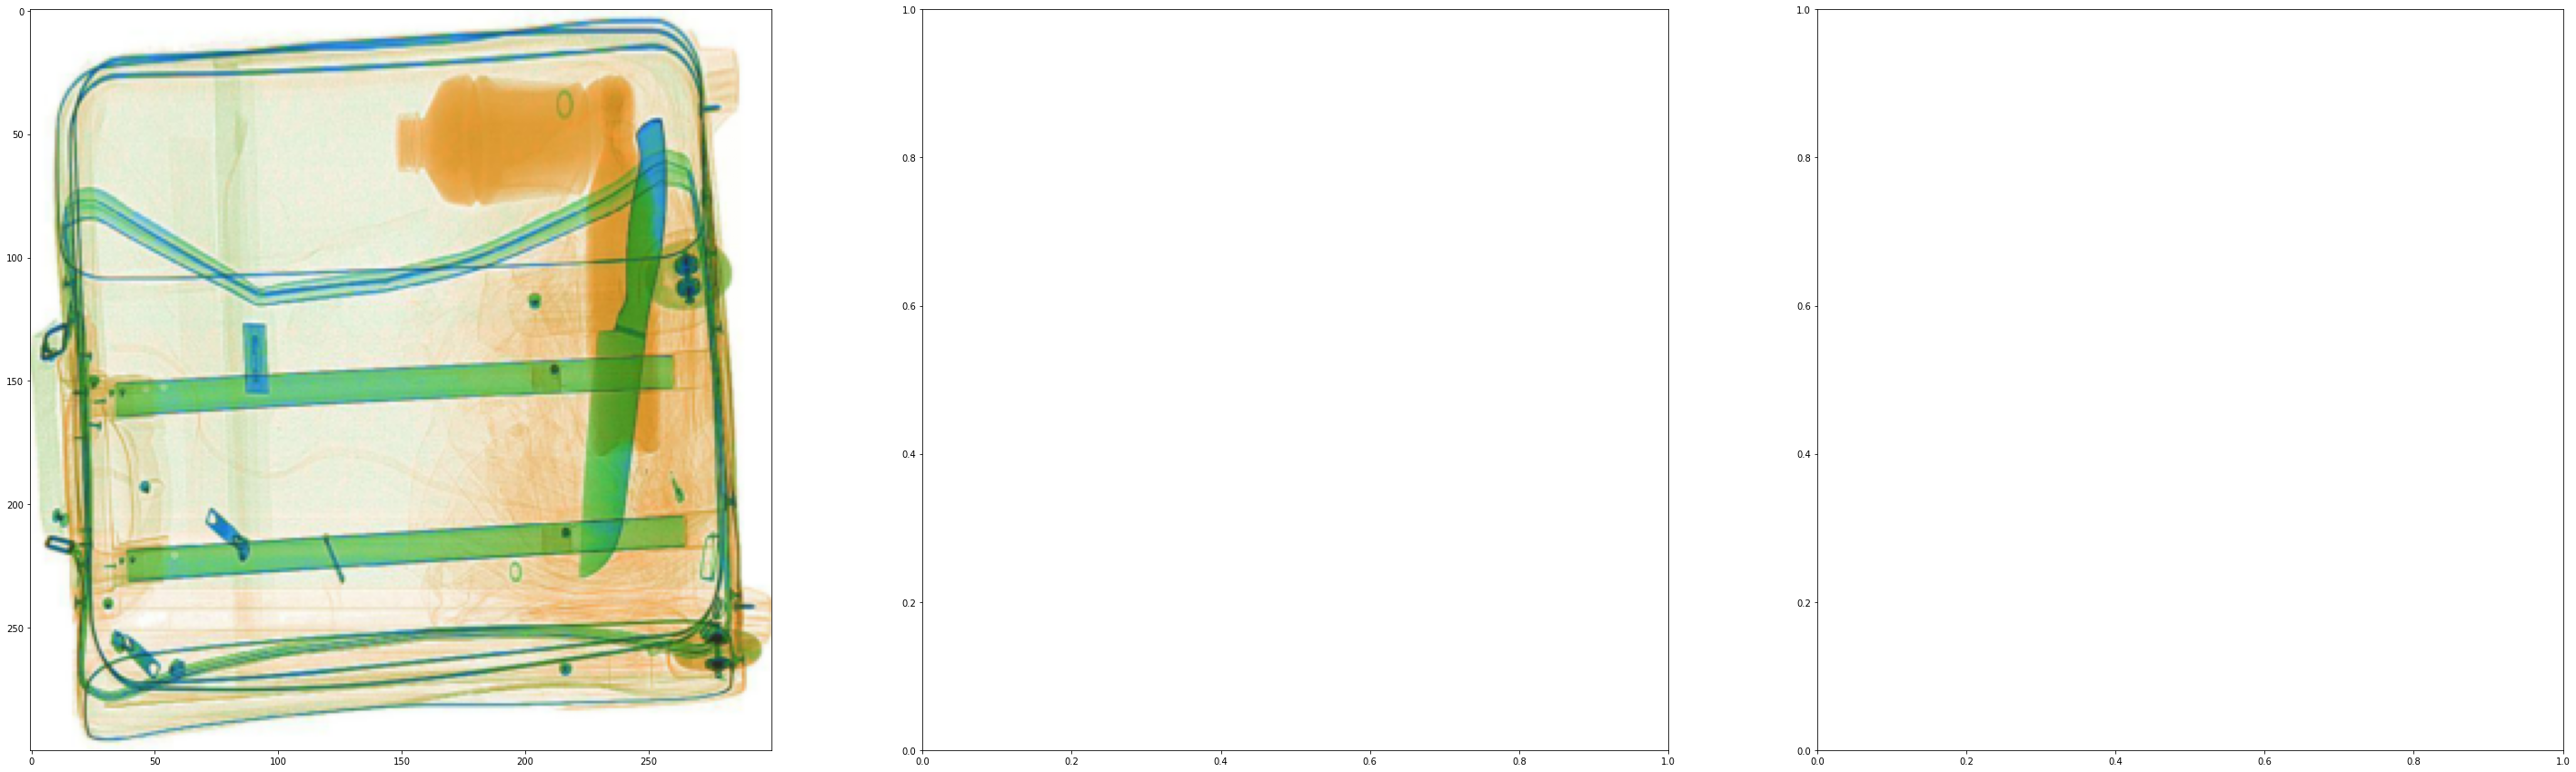

In [ ]:
img,boxes,labels = next(iter(test_dataloader))
imgs = [image.to(device) for image in img]
outputs = model(imgs)
          
      
pred_bboxes=outputs[0]["boxes"]
pred_labels=outputs[0]["labels"]
pred_scores=outputs[0]["scores"]
idx_to_class = {0:"background",1:"Gun", 2:"Knife", 3:"Wrench"}
fig, ax = plt.subplots(1, 3, figsize=(50, 15))
for i in range(3):
  ax[i].imshow(img[i].permute(1, 2, 0))
  for box in boxes[i]:
    rect = plt.Rectangle((box[0], box[1]),box[2]-box[0],box[3]-box[1], fill=False, edgecolor = 'blue',linewidth=1)
    ax[i].text(box[0], box[3], idx_to_class[labels[i]] ,size=5,color="blue", alpha=0.5)
    ax[i].add_patch(rect)

  for i,pre_box in enumerate(pred_bboxes):
    rect = plt.Rectangle((pre_box[0], pre_box[1]),pre_box[2]-pre_box[0],pre_box[3]-pre_box[1], fill=False, edgecolor = 'red',linewidth=1)
    info= "Type: {} Confidence: {}".format(idx_to_class[pred_labels[i]],pred_scores[i])
    ax[i].text(pre_box[0], pre_box[3], info,size=5,color="red", alpha=0.5)
    ax[i].add_patch(rect)


plt.show() 